Test By CzaOrz

In [1]:
# 导包
import json
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict, deque

from tree import createTree

In [14]:
"""加载数据"""
tasks = ("人事变动", "领导之窗")
def get_data(*names):
    for name in names:
        with open('%s.json' % name, 'r', encoding='utf-8') as json_file:
            yield json.loads(json_file.read())[name]
def merge_data(*args):
    res = []
    sta = []
    for data in args:
        res.extend(data)
        sta.append(len(data))
    return res, sta
fina, stat = merge_data(*[data for data in get_data(*tasks)])
stat = dict(zip(tasks, stat))

{'人事变动': 4929, '领导之窗': 4984}

In [15]:
"""清洗数据"""

# 获取过滤目标
dupefilter = ['疑难网站', '网站异常', '驳回需求', '运维发现异常', '废弃需求', '停止维护', '网站异常']
def get_filter_spider_name(data_list, dupefilter=()):
    filter_spider = set()
    for data in data_list:
        if data['rwzt'] in dupefilter or data['spiderName'].count('-') != 2:
            filter_spider.add(data['spiderName'])
    return filter_spider
# 获取爬虫任务
def get_spider_tasks(data_list, dupefilter=()):
    spider_tasks = defaultdict(list)
    for data in data_list:
        if data['spiderName'] in dupefilter:
            continue
        spider_tasks[data['spiderName']].append(data)
    return spider_tasks
filter_spider_name = get_filter_spider_name(fina, dupefilter)
spider_tasks = get_spider_tasks(fina, filter_spider_name)
res = {}
for task in spider_tasks:
    feild = task.split('-', 1)[0]
    res[feild] = res.get(feild, 0) + 1
res

{'人事变动': 312, '领导之窗': 351}

In [4]:
"""爬虫任务-开发流程模型"""
class AbnormalTask(Exception): pass
class SpiderTaskProcess:
    state = 'rwzt'
    time = 'time'
    def __init__(self, data):
        self.source = copy.deepcopy(data)
        self.data = data
        self.developer_time = 0
        self.developer_times = 0
        self.tester_time = 0
        self.tester_times = 0
        self.storager_time = 0
        self.storager_times = 0
    def statistics_dict(self):
        developer_time = self.developer_time//self.developer_times
        tester_time = self.tester_time//self.tester_times
        storager_time = self.storager_time//self.storager_times
        return dict(developer_time=developer_time,
                    developer_times=self.developer_times,
                    tester_time=tester_time,
                    tester_times=self.tester_times,
                    storager_time=storager_time,
                    storager_times=self.storager_times,
                    total_time=developer_time+tester_time+storager_time)
    def _get_state_time(self, state):
        if not isinstance(state, tuple) and not isinstance(state, list):
            state = [state]
        flag = time_use = label = None
        for index, data in enumerate(self.data):
            if data[self.state] in state:
                flag = index + 1
                time_use = data[self.time]
                try:
                    label = data[self.state]
                    if self.data[flag][self.state] in state:
                        continue
                except:
                    break
                self.data = self.data[index:]
                break
        if not flag:
            raise AbnormalTask
        return time_use, label
    def _process_task(self, start, end):
        time1, label1 = self._get_state_time(start)
        time2, label2 = self._get_state_time(end)
        return time2-time1, label2
    def check_tester_wrong(self, state1=('驳回测试修改意见', '清洗修改完成'), state2=('驳回测试修改意见')):
        try:
            return self.data[1][self.state] in state1 or \
                   self.data[2][self.state] in state2
        except:
            raise AbnormalTask
    def check_storager_wrong(self, state1=('正在入库')):
        try:
            return self.data[1][self.state] in state1
        except:
            raise AbnormalTask
    def get_developer(self, start=('开发完成','返回修改'), end=('开发完成','研发修改完成')):
        if self.check_tester_wrong():
            return self.get_tester()
        elif self.check_tester_wrong(('正在测试')):
            return self.get_tester(('正在测试'))
        elif self.check_storager_wrong():
            return self.get_storager(('返回修改'), ('入库完成'))
        else:
            time_diff, label = self._process_task(start, end)
        self.developer_time += time_diff
        self.developer_times += 1
        return label
    def get_tester(self, start=('清洗修改完成', '驳回测试修改意见'), end=('返回修改', '测试查完成')):
        time_diff, label = self._process_task(start, end)
        self.tester_time += time_diff
        self.tester_times += 1
        return label
    def get_storager(self, start=('测试查完成'), end=('返回修改', '入库完成')):
        time_diff, label = self._process_task(start, end)
        self.storager_time += time_diff
        self.storager_times += 1
        return label
    def process_label(self, label):
        if label in ['返回修改']:
            label = self.get_developer()
        elif label in ['开发完成', '研发修改完成']:
            label = self.get_tester()
        elif label in ['测试查完成']:
            label = self.get_storager()
        elif label in ['入库完成']:
            return
        self.process_label(label)
    def process(self):
        time_diff, label = self._process_task(['待处理','正在开发'], ['开发完成'])
        self.developer_time += time_diff
        self.developer_times += 1
        self.process_label(label)
        return self
# 归一化处理
minute=60
hour=minute*60
day=hour*24
two_day=day*2
five_day=day*5
def process_key_to_new_value(data, value, *keys):
    for key in keys:
        if data[key] < two_day:
            data[key] = value[0]
        elif data[key] < five_day:
            data[key] = value[1]
        else:
            data[key] = value[2]
def process_spider_task_statistics(task):
    _task = copy.deepcopy(task)
    process_key_to_new_value(_task, ('green', 'yellow', 'red'), *['total_time'])
    get_each_task_time(_task, ('total_time',))
    process_key_to_new_value(task, ('good', 'normal', 'whats'), *['developer_time','tester_time','storager_time'])
    process_key_to_new_value(task, ('level1', 'level2', 'level3'), *['total_time'])
# 获取各类事件的时间
class TimerManager:
    developer_time = []
    tester_time = []
    storager_time = []
    total_time = []
    details_information = []
    def get_merge_data(self):
        res = []
        res.extend(self.developer_time)
        res.extend(self.tester_time)
        res.extend(self.storager_time)
        return res
    def get_pointer(self):
        res = set(self.get_merge_data())
        return min(res), max(res)
    def to_normalized(self):
        min_time, max_time = self.get_pointer()
        denominator = min_time + max_time
        self.developer_time = [data/denominator for data in self.developer_time]
        self.tester_time = [data/denominator for data in self.tester_time]
        self.storager_time = [data/denominator for data in self.storager_time]
def get_each_task_time(task, labels=()): # 'developer_time', 'tester_time', 'storager_time'
    for label in labels:
        getattr(TimerManager, label).append(task[label])
def get_details_information(spider_name, data, labels=()):
    info = {'spiderName': spider_name}
    for label in labels:
        info[label] = data[label]
    getattr(TimerManager, 'details_information').append(info)

In [17]:
"""输出数据"""
labels=deque()
dataSets=[]
for spider_name, spider_task in spider_tasks.items():
    spider_task = sorted(spider_task, key=lambda task: task['time'])
    try:
        spider_task_statistics = SpiderTaskProcess(spider_task).process().statistics_dict()
    except AbnormalTask:
        continue
    get_details_information(spider_name, spider_task_statistics, ('developer_time', 'tester_time', 'storager_time', 'total_time'))
    get_each_task_time(spider_task_statistics, ('developer_time', 'tester_time', 'storager_time'))
    process_spider_task_statistics(spider_task_statistics)
    if not labels:
        for key in spider_task_statistics.keys():
            if key == 'total_time':
                labels.append(key)
            else:
                labels.appendleft(key)
    dataSet = []
    for label in labels:
        dataSet.append(spider_task_statistics.pop(label))
    dataSets.append(dataSet)
labels = list(labels)
labels.pop()
pass

In [6]:
"""输出数据到决策树模型"""
trees = createTree(dataSets, labels)

In [7]:
time_man = TimerManager()
time_man.to_normalized()

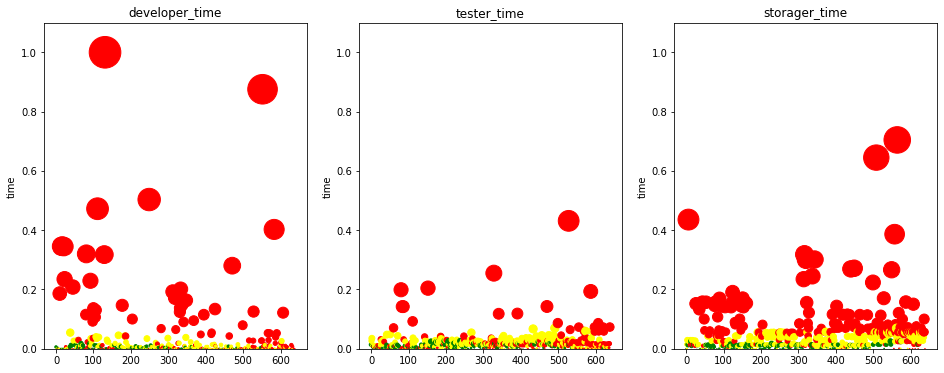

In [8]:
fig, ax = plt.subplots(1,3)
def draw_time_distribution(ax, i, property, title):
    x = range(len(getattr(time_man, property)))
    y = getattr(time_man, property)
    size = np.array(getattr(time_man, property)) * 1000
    color = time_man.total_time
    ax[i].scatter(x, y, size, color)
    ax[i].set_title(title)
    ax[i].set_ylim(0, 1.1)
    ax[i].set_ylabel('time')
draw_time_distribution(ax, 0, 'developer_time', 'developer_time')
draw_time_distribution(ax, 1, 'tester_time', 'tester_time')
draw_time_distribution(ax, 2, 'storager_time', 'storager_time')
# plt.scatter(x, y, size, color)
fig.set_size_inches(16, 6)
# plt.show()

In [9]:
columns = ['spiderName', 'developer_time', 'tester_time', 'storager_time', 'total_time']
dataSets = []
for task in TimerManager().details_information:
    dataSet = []
    for label in columns:
        dataSet.append(task[label])
    dataSets.append(dataSet)

In [10]:
df = pd.DataFrame(np.array(dataSets), columns=columns)
df['total_time']=df['total_time'].astype(int)  # apply(lambda x:int(x))
df.sort_values(by='total_time', ascending=False).head(10)

,spiderName,developer_time,tester_time,storager_time,total_time
131,人事变动-景德镇市-360200,6023632,10259,493345,6527236
552,领导之窗-定安县-469021,5272541,102034,406145,5780720
528,领导之窗-潮州市-445100,756373,2599147,1027263,4382783
564,领导之窗-攀枝花市-510400,7667,123492,4243363,4374522
508,领导之窗-娄底市-431300,6541,275742,3884203,4166486
249,人事变动-资阳市-512000,3032121,178736,326554,3537411
111,人事变动-马鞍山市-340500,2845764,556978,17204,3419946
583,领导之窗-六盘水市-520200,2425082,4956,423165,2853203
6,人事变动-吉林省-220000,5401,50183,2624865,2680449
337,领导之窗-孝感市-420900,902159,74579,1475293,2452031


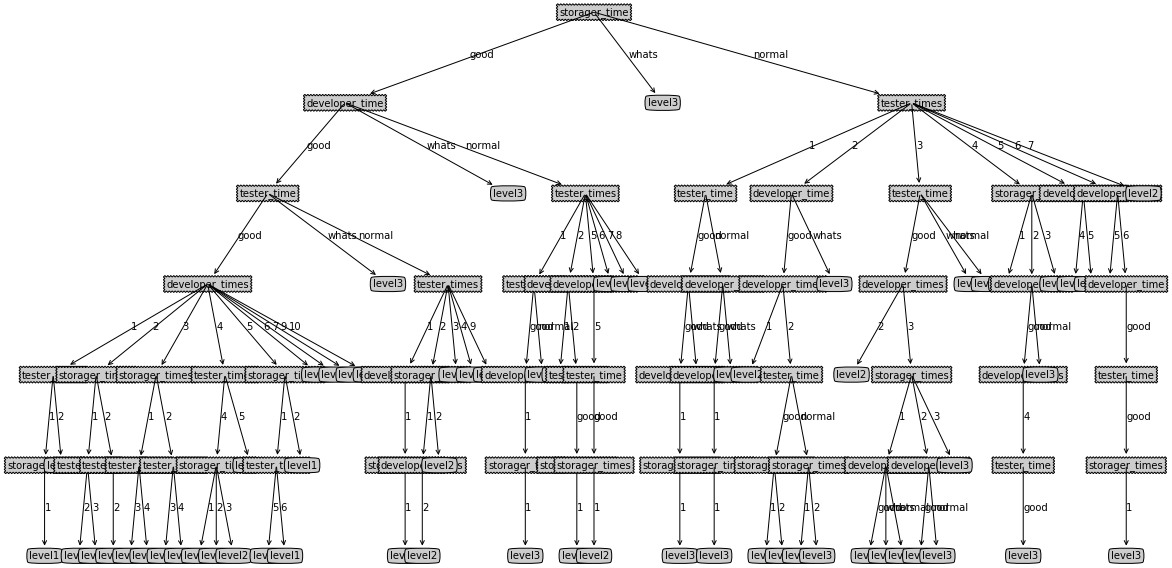

In [11]:
import matplotlib.pyplot as plt

# 定义文本框和箭头格式
decisionNode = dict(boxstyle='sawtooth', fc='0.8')
leafNode = dict(boxstyle='round4', fc='0.8')
arrow_args = dict(arrowstyle='<-')


# 使用文本注解绘制树节点
def plotNode(nodeTxt, cencerPt, parentPt, nodeType):
    createPlot.axl.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=cencerPt, textcoords='axes fraction',
                            va='center', ha='center', bbox=nodeType, arrowprops=arrow_args)


# 获取叶节点的数目
def getNumLeafs(mytree):
    numLeafs = 0
    firstStr = list(mytree.keys())[0]
    secondDict = mytree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs


# 获取决策树的层数
def getTreeDepth(mytree):
    maxDepth = 0
    firstStr = list(mytree.keys())[0]
    secondDict = mytree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth


# 在父子节点之间填充文本信息
def plotMidText(centerPt, parentPt, txtString):
    xMid = (parentPt[0] - centerPt[0]) / 2.0 + centerPt[0]
    yMid = (parentPt[1] - centerPt[1]) / 2.0 + centerPt[1]
    createPlot.axl.text(xMid, yMid, txtString)


def plotTree(mytree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(mytree)
    depth = getTreeDepth(mytree)
    firstSides = list(mytree.keys())
    firstStr = firstSides[0]  # 划分数据集的特征
    centerPt = (
        plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, plotTree.yOff)  # x轴右移，(1+叶节点数目)/(2*决策树宽度)，y轴不变
    plotMidText(centerPt, parentPt, nodeTxt)  # 绘制父子节点之间的文本标签（对于划分数据集的特征，其实没有文本标签）
    plotNode(firstStr, centerPt, parentPt, decisionNode)  # 绘制父节点与指向子节点的箭头
    secondDict = mytree[firstStr]  # 划分数据集特征的取值
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD  # y轴下移，1/决策树深度
    for key in secondDict.keys():
        # 如果分支下还有子树，调用函数本身，递归完成该分支的绘制
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], centerPt, str(key))
        # 如果分支下没有子树，仅一种分类结果，绘制叶子节点，添加父子节点之间的文本标签
        else:
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW  # x轴右移，1/(2*决策树宽度)
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), centerPt, leafNode)  # 绘制叶子节点
            plotMidText((plotTree.xOff, plotTree.yOff), centerPt, str(key))  # 添加父子节点之间的文本标签
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD  # y轴上移，恢复初始值，确保另外一个分支父节点的位置正确


def createPlot(intree):
    fig = plt.figure(1, facecolor='white')  # 创建一个新图形，前景色为白色
    fig.clf()  # 清空绘图区
    fig.set_size_inches(20, 10)
    axprops = dict(xticks=[], yticks=[])  # 定义坐标轴（空白）
    createPlot.axl = plt.subplot(111, frameon=False, **axprops)  # 创建子图，无边框，无坐标值
    plotTree.totalW = float(getNumLeafs(intree))  # 设置全局变量，记录决策树的宽带
    plotTree.totalD = float(getTreeDepth(intree))  # 设置全局变量，记录决策树的深度
    plotTree.xOff = -0.5 / plotTree.totalW  # 设置全局变量，追踪节点的x轴坐标
    plotTree.yOff = 1.0  # 设置全局变量，追踪节点的y轴坐标
    plotTree(intree, (0.5, 1.0), '')
    plt.show()

createPlot(trees)